In [48]:
## Lib's needed
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from __future__ import print_function
# Import for spliting the data set
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
# Imports for classificaiton 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
from sklearn import metrics as mt

# Set the figure sizes for the project 
rcParams['figure.figsize'] = 10, 10
rcParams.update({'font.size': 18})

## Bring in data and perform some EDA

In [2]:
def corr_matrix(df):
    '''Generates Correlation Matrix'''
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = (15, 10))
    colormap = sns.diverging_palette(240, 10, n = 9, as_cmap = True)
    sns.heatmap(corr, mask = mask, cmap = colormap, center = 0,
                square = True, linewidths = .5, cbar_kws = {"shrink": 1})

In [50]:
# Now that we have a data dictionary, we can get rid of many of the irrelevant columns. I selected this particular subset also using some forestry knowledge (doubtful of the various volume variables contribution to crown class)
fields = ['CLUSTER','ID',
'tree_obs_id','tree_spp',
'tree_dbh','tree_stems',
'tree_height','tree_crown_class',
'tree_stems_per','tree_ba',
'stand_id','OverOb_wOverIDForTypBAFGrndPresCrzrSoilWet_over_id'
]

#Create a dataframe from just the subset of cols using same dataset from original notebook.
raw_trees = pd.read_csv("FinalOverObTableWAR.csv", usecols = fields)


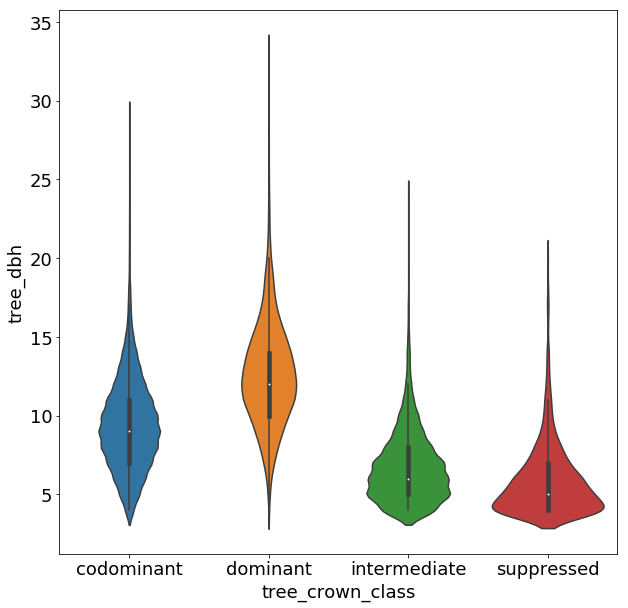

In [51]:
# Tree DBH vs Tree Crown Class
sns.violinplot(x = 'tree_crown_class', y = 'tree_dbh', data = raw_trees)

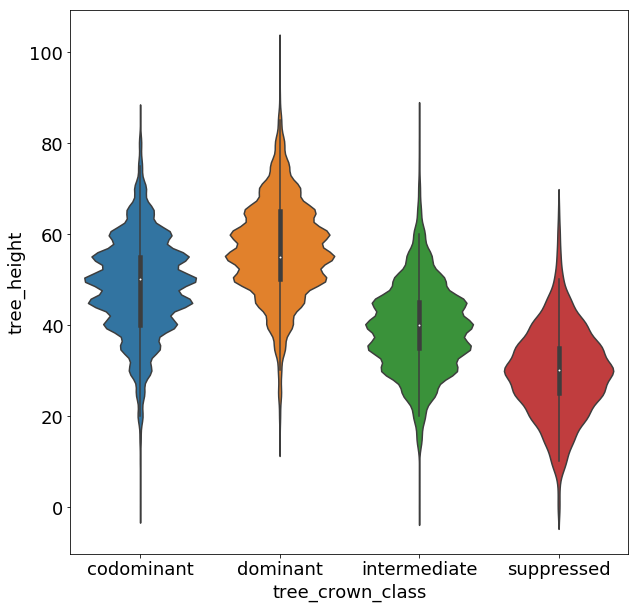

In [52]:
# Tree Height vs Tree Crown Class
sns.violinplot(x = 'tree_crown_class', y = 'tree_height', data = raw_trees)

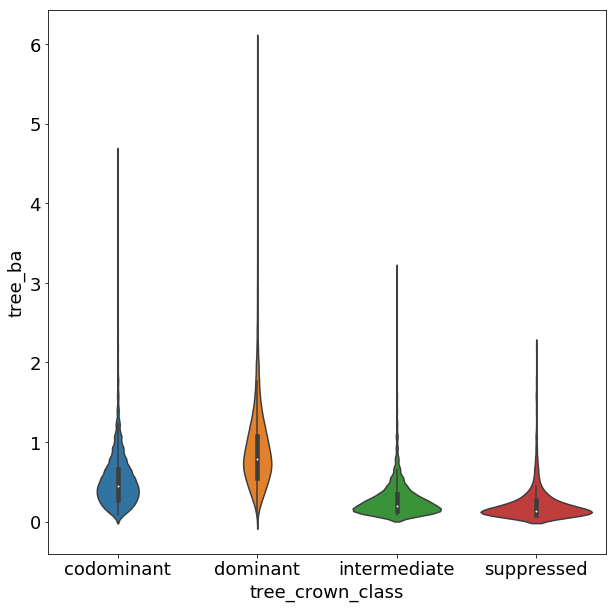

In [53]:
# Tree Crown Condtion vs Tree Crown Class
sns.violinplot(x = 'tree_crown_class', y = 'tree_ba', data = raw_trees)

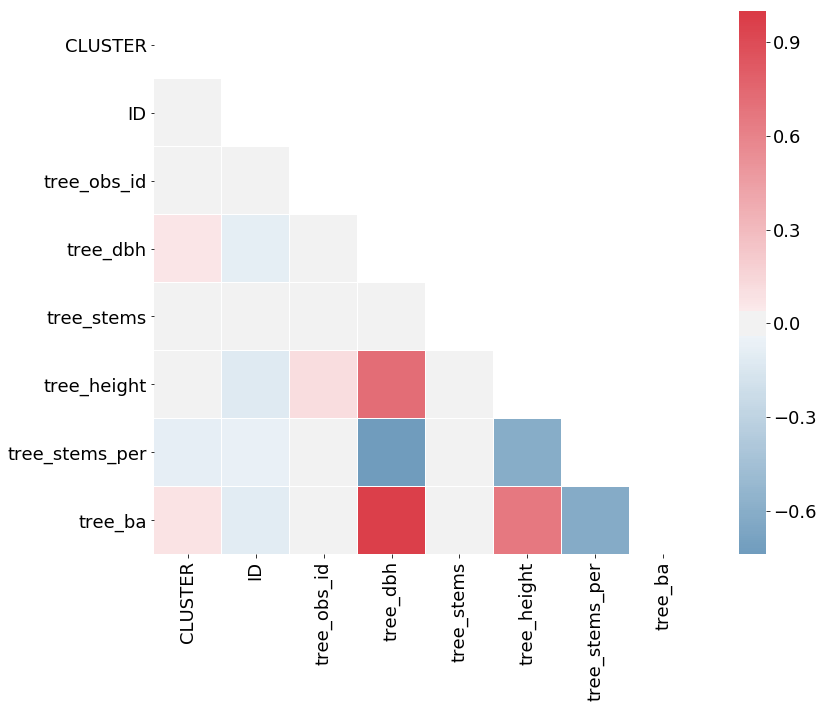

In [54]:
corr_matrix(raw_trees)

## Feature Engineering

In [84]:
fe_data = raw_trees

We know that tree height is collected in 5 ft bins, which limits the resolution and categorical variables can be tricky. 
One way to convert it would be to add some random noise between (0,1) to each height bin that it falls in. 
This won't change the bin and it won't change the relation between trees.

In [85]:
fe_data['tree_height_cont'] = fe_data['tree_height'] + [random.random() for _ in range(0, len(fe_data))]

fe_data[['tree_height','tree_height_cont']].head(10)

,tree_height,tree_height_cont
0,65,65.051182
1,55,55.397211
2,50,50.455515
3,40,40.782300
4,65,65.058481
5,70,70.105039
6,65,65.242326
7,65,65.980833
8,65,65.370074
9,55,55.719713


In [86]:
fe_data['ht_percentile_stand'] = fe_data.groupby('stand_id')['tree_height_cont'].rank(pct=True)
fe_data['BA_percentile_stand'] = fe_data.groupby('stand_id')['tree_ba'].rank(pct=True)

fe_data['ht_percentile_plot'] = fe_data.groupby('OverOb_wOverIDForTypBAFGrndPresCrzrSoilWet_over_id')['tree_height_cont'].rank(pct=True)
fe_data['BA_percentile_plot'] = fe_data.groupby('OverOb_wOverIDForTypBAFGrndPresCrzrSoilWet_over_id')['tree_ba'].rank(pct=True)

fe_data['ht_percentile_ratio'] = fe_data['ht_percentile_plot'] / fe_data['ht_percentile_stand'] 
fe_data['BA_percentile_ratio'] = fe_data['BA_percentile_plot'] / fe_data['BA_percentile_stand']


In [87]:
fe_data.head()

,CLUSTER,ID,tree_obs_id,tree_spp,tree_dbh,tree_stems,tree_height,tree_crown_class,tree_stems_per,tree_ba,OverOb_wOverIDForTypBAFGrndPresCrzrSoilWet_over_id,stand_id,tree_height_cont,ht_percentile_stand,BA_percentile_stand,ht_percentile_plot,BA_percentile_plot,ht_percentile_ratio,BA_percentile_ratio
0,316,11638,5,PIRI,20,1,65,codominant,4.583662,2.181662,POKWAR047,POK,65.051182,0.923764,0.996951,1.000000,1.000000,1.082528,1.003059
1,316,11639,6,PIRI,10,1,55,dominant,18.334649,0.545415,POKWAR047,POK,55.397211,0.726639,0.527990,0.785714,0.464286,1.081299,0.879346
2,316,11640,7,PIRI,11,1,50,codominant,15.152603,0.659953,POKWAR047,POK,50.455515,0.563712,0.639621,0.642857,0.607143,1.140401,0.949223
3,52,40,2,PIRI,8,1,40,intermediate,85.943669,0.349066,cswwar006,CSW,40.782300,0.189456,0.269357,0.111111,0.388889,0.586473,1.443765
4,53,41,11,CHTH2,13,1,65,codominant,32.546715,0.921752,cswwar007,CSW,65.058481,0.635914,0.743822,0.363636,0.727273,0.571832,0.977751


In [88]:
fe_data.shape

(16575, 19)

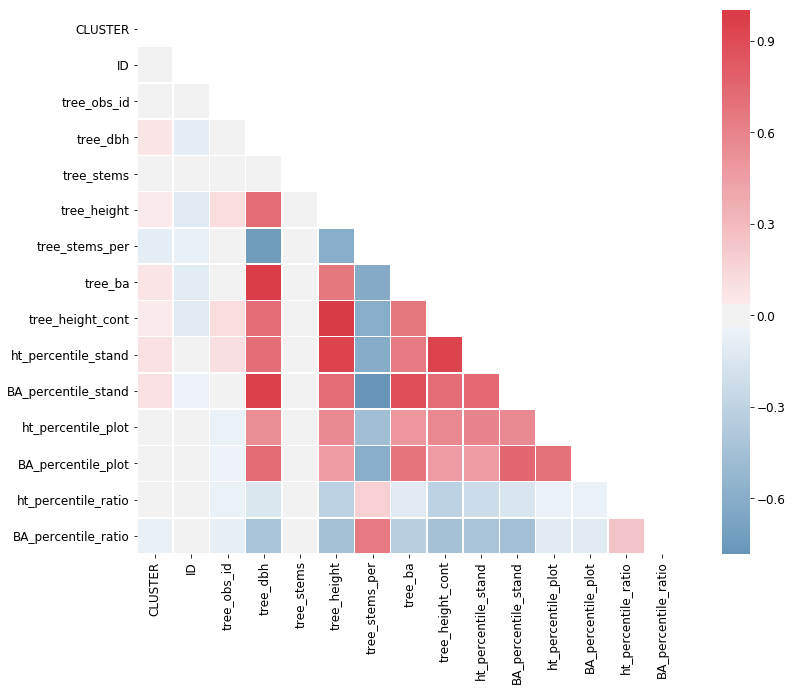

In [89]:
corr_matrix(fe_data)

In [90]:
# Let's take out some variable's e dont need
tree_data = fe_data.drop(labels=['CLUSTER', 
                                 'ID', 
                                 'OverOb_wOverIDForTypBAFGrndPresCrzrSoilWet_over_id',
                                 'tree_spp',
                                 'stand_id'
                                ],
                        axis=1)

In [91]:
tree_data.head()

,tree_obs_id,tree_dbh,tree_stems,tree_height,tree_crown_class,tree_stems_per,tree_ba,tree_height_cont,ht_percentile_stand,BA_percentile_stand,ht_percentile_plot,BA_percentile_plot,ht_percentile_ratio,BA_percentile_ratio
0,5,20,1,65,codominant,4.583662,2.181662,65.051182,0.923764,0.996951,1.000000,1.000000,1.082528,1.003059
1,6,10,1,55,dominant,18.334649,0.545415,55.397211,0.726639,0.527990,0.785714,0.464286,1.081299,0.879346
2,7,11,1,50,codominant,15.152603,0.659953,50.455515,0.563712,0.639621,0.642857,0.607143,1.140401,0.949223
3,2,8,1,40,intermediate,85.943669,0.349066,40.782300,0.189456,0.269357,0.111111,0.388889,0.586473,1.443765
4,11,13,1,65,codominant,32.546715,0.921752,65.058481,0.635914,0.743822,0.363636,0.727273,0.571832,0.977751


## Splitting the data into training and testing sets

The goal of performing cross-validation is to split our data into a training set and test set. The training set is split up into multiple validation sets. We are going to use stratified K-fold cross-validation with 10 splits (K=10) for our classification tasks. This is because our data is unbalanced. There is a total of 17,426 observations in our data set. Out of all the observations, 8,022 observations are made up of co-dominate trees (about half). Stratified K-fold cross-validation ensures that each of our training sets contains an equal proportion of each unbalanced variable.

In [93]:
# Split the data into traning (80%) and test set (20%)
# We are using stratified cross validation here because the majority of the
#    individuals in the variable we want to classify are codominant
if 'tree_crown_class' in tree_data:
    y = tree_data['tree_crown_class'].values # get values we need 
    del tree_data['tree_crown_class']        # get rid of the class label
    X = tree_data.values                     # use everything else to classify 

# X = pd.get_dummies(tree_data).values

# Scale attributes by the training set
# scl = StandardScaler()
# X = scl.fit_trabnsform(X)

# Split the data into 20% Test and 80% Train using StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.20, random_state=111)
sss.get_n_splits(X, y) #retreving the splits

3

In [94]:
X.shape

(16575, 13)

In [95]:
print("These are the Stratified Shuffle Split parameters:")
print("---------------------------------------------------")
print(sss)

These are the Stratified Shuffle Split parameters:
---------------------------------------------------
StratifiedShuffleSplit(n_splits=3, random_state=111, test_size=0.2,
            train_size=None)


In [96]:
# Create a for loop that grabs the values for each fold for traing and test sets
for train_index, test_index in sss.split(X, y):
    # Let's print them out just for a sanity check
    print("TRAIN:", train_index, "TEST:", test_index)
    # Create the X train/test and y train/test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 7968 13010  3166 ...  9730  3442  2376] TEST: [12695  9400 10896 ...  2347 12289  5015]
TRAIN: [ 9027  4914 11653 ... 15659 13836  2036] TEST: [16523  1882  6998 ...  6901 16026  2639]
TRAIN: [ 3626 12012   780 ...  4275  8684  2544] TEST: [12136  2691 11371 ...  5807  1501  1732]


## Let's Classify
Now thaat we have our training and testing sets, we will use thje Random forest method. At the end of this section we will assess the precision, recall, f1-score, and support.

### Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

---- Iteration 0  ----
RF Accuracy = 0.6582202111613876
__________________________________________________
RF Metric Report
              precision    recall  f1-score   support

  codominant       0.65      0.80      0.72      1604
    dominant       0.73      0.61      0.67       969
intermediate       0.55      0.43      0.48       539
  suppressed       0.62      0.39      0.48       203

   micro avg       0.66      0.66      0.66      3315
   macro avg       0.64      0.56      0.59      3315
weighted avg       0.66      0.66      0.65      3315



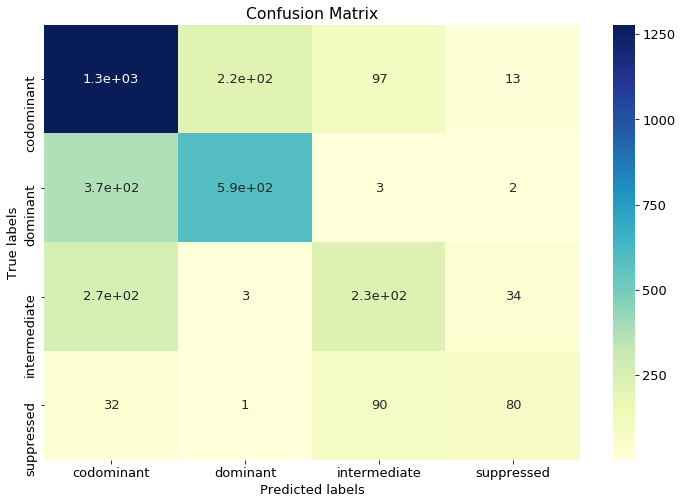

---- Iteration 1  ----
RF Accuracy = 0.6542986425339367
__________________________________________________
RF Metric Report
              precision    recall  f1-score   support

  codominant       0.65      0.80      0.72      1604
    dominant       0.74      0.63      0.68       969
intermediate       0.52      0.40      0.45       539
  suppressed       0.55      0.33      0.41       203

   micro avg       0.65      0.65      0.65      3315
   macro avg       0.62      0.54      0.56      3315
weighted avg       0.65      0.65      0.64      3315



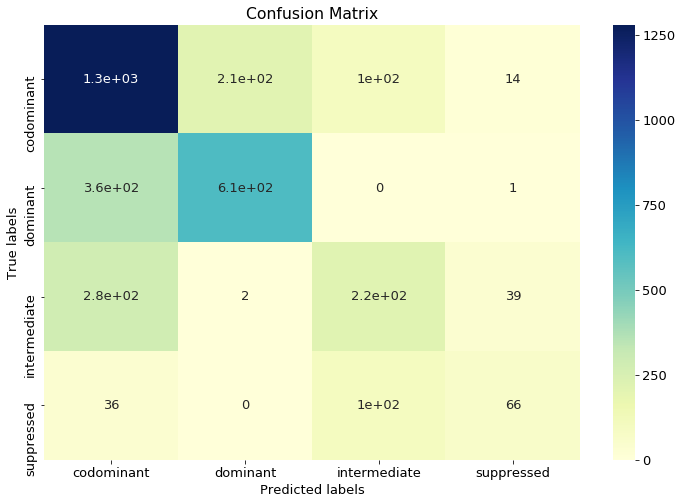

---- Iteration 2  ----
RF Accuracy = 0.6392156862745098
__________________________________________________
RF Metric Report
              precision    recall  f1-score   support

  codominant       0.64      0.77      0.70      1604
    dominant       0.69      0.61      0.65       969
intermediate       0.52      0.42      0.46       539
  suppressed       0.59      0.34      0.43       203

   micro avg       0.64      0.64      0.64      3315
   macro avg       0.61      0.53      0.56      3315
weighted avg       0.64      0.64      0.63      3315



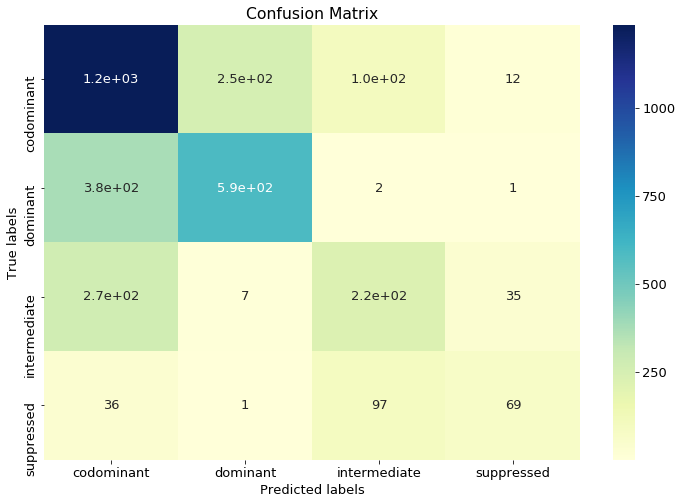

In [109]:
# In this snippet we use a RandomForestClassifier

# n_estimators <- The number of trees in the forest
# criterion <- The function to measure the quality of a split. Supported criteria are “gini” for 
#              the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific
# max_depth <- The maximum depth of the tree. If None, then nodes are expanded until all 
#              leaves are pure or until all leaves contain less than min_samples_split samples
# min_samples_split <- The minimum number of samples required to split an internal node (default = 2)
# max_features <- The number of features to consider when looking for the best split

RF = RandomForestClassifier(
    n_estimators = 250,
    max_depth = 5,
    max_features = 'log2',
    min_samples_split = 2,
    criterion = 'entropy',
    random_state = 111)

# RF_pipe = Pipeline([('PCA', PCA(n_components = 5, svd_solver = 'randomized')),
#                     ('classification', RandomForestClassifier(n_estimators = 300,
# #                                                               max_depth = 10,
#                                                               max_features = 'log2',
#                                                               min_samples_split = 2,
#                                                               criterion = 'entropy',
#                                                               random_state = 111))
#                     ])

# Next we need to iterate through and get the prediction, like we did above
iter_num = 0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X, y): 
    X_train = X[train_indices]  # train indices for X
    y_train = y[train_indices]  # train indices for y
    
    X_test = X[test_indices]    # test indices for X
    y_test = y[test_indices]    # test indices for y
    
    # train the reusable KNN classifier on the training data
    RF.fit(X_train, y_train)    # train object
    y_hat = RF.predict(X_test) # get test set precitions
    
    # accuracy for the iterations of training/testing
    # obtain accuracies for each iteration 
    accuracy_RF = mt.accuracy_score(y_test, y_hat)
    # print out each numbered iteration 
    print("---- Iteration", iter_num, " ----")
    print('RF Accuracy =', accuracy_RF)
    print("__________________________________________________")
    
    # Metric report
    # Obtain metric's report for each iteration 
    metrics_RF = classification_report(y_test, y_hat)
    print('RF Metric Report')
    print(metrics_RF)
    
    # Confusion Matrix
    rcParams.update({'font.size': 13})
    rcParams['figure.figsize'] = 12, 8
    ax = plt.subplot()
    sns.heatmap(confusion_matrix(y_test, y_hat), annot=True, cmap="YlGnBu", ax = ax)
    # Labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['codominant', 'dominant', 'intermediate', 'suppressed'])
    ax.yaxis.set_ticklabels(['codominant', 'dominant', 'intermediate', 'suppressed'])
    plt.show()
    
    # Run through the first iteration, then second, then third ... then tenth
    iter_num += 1

In [111]:
# Get the mean accuracy
# This also can help with parallelism
accuracies_RF = cross_val_score(RF, X, y=y, cv=sss)
# Print out the mean 
mean_RF = np.mean(accuracies_RF).round(2)
print("The mean accuracy for this model is ", mean_RF)

The mean accuracy for this model is  0.65


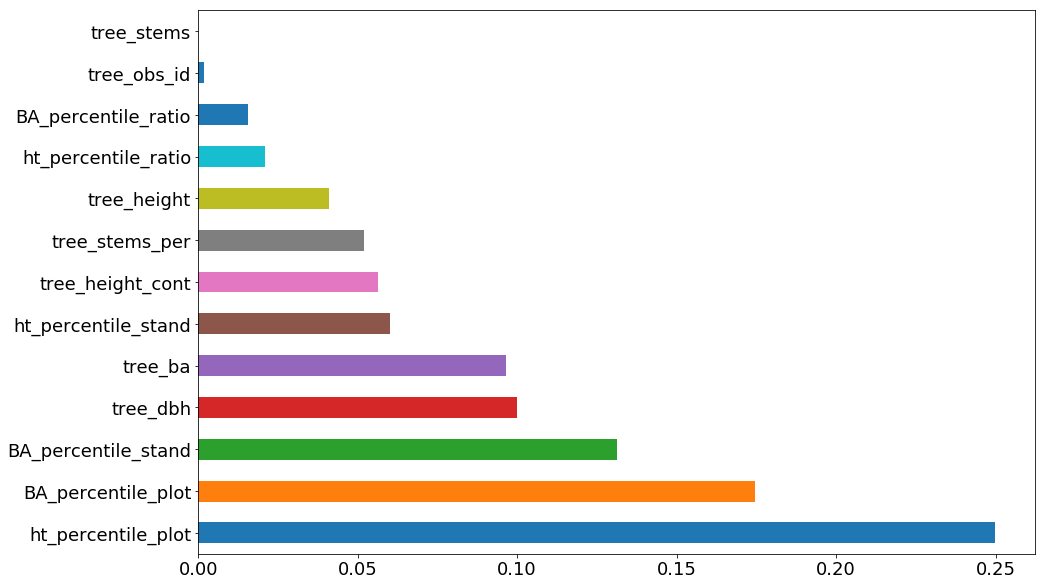

In [113]:
# Feature Importance
rcParams['figure.figsize'] = 15, 10
rcParams.update({'font.size': 18})
feat_importances = pd.Series(RF.feature_importances_, index=tree_data.columns)
feat_importances.nlargest(13).plot(kind='barh')
plt.show()